# Simulate ice with OpenMM

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

from tqdm.auto import trange

import mdtraj as md
import nglview as nv

In [3]:
import openmm, openmm.app
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [4]:
#some useful stuff
def water_mdtraj_topology(n_waters, n_sites=3):
    H = md.element.Element.getBySymbol('H')
    O = md.element.Element.getBySymbol('O')
    VS = md.element.Element.getBySymbol('VS')
    water_top = md.Topology()
    water_top.add_chain()
    for i in range(n_waters):
        water_top.add_residue('HOH', water_top.chain(0))
        water_top.add_atom('O', O, water_top.residue(i))
        water_top.add_atom('H1', H, water_top.residue(i))
        water_top.add_atom('H2', H, water_top.residue(i))
        if n_sites == 4:
            water_top.add_atom('M', VS, water_top.residue(i))
        water_top.add_bond(water_top.atom(n_sites*i), water_top.atom(n_sites*i+1))
        water_top.add_bond(water_top.atom(n_sites*i), water_top.atom(n_sites*i+2))
    return water_top

def get_view(positions,  box):
    if len(positions.shape) == 3 and len(box.shape) == 1:
        all_boxes = np.full((len(positions),len(box)), box)
    else:
        all_boxes = box
    unitcell = {'unitcell_lengths' : all_boxes,
                'unitcell_angles' : np.full(all_boxes.shape, 90)}

    view = nv.show_mdtraj(md.Trajectory(positions, model.mdtraj_topology, **unitcell))
    view.add_unitcell()
    view.add_representation('ball+stick', selection="water")
    return view

class ModelWrapper():
    def __init__(self, system: openmm.System, mdtraj_topology: md.Topology, positions: np.ndarray):
        assert system.getNumParticles() == mdtraj_topology.n_atoms
        assert len(positions) == system.getNumParticles()
        self.system = system
        self.mdtraj_topology = mdtraj_topology
        self.topology = mdtraj_topology.to_openmm()
        self.positions = positions

In [5]:
#load system from file
temp = 270
water_type = 'tip4pew'
info = f'iceIh_{water_type}-T{temp}'

box = np.load(f'data-{info}.npz')['box']
positions = np.load(f'data-{info}.npz')['positions']
with open(f'system-{info}.xml') as input:
    system = openmm.XmlSerializer.deserialize(input.read())

default_box_tensor = np.array([a.value_in_unit(unit.nanometer) for a in system.getDefaultPeriodicBoxVectors()])
if not np.allclose(np.eye(3)*box, default_box_tensor):
    print('WARNING: box mismatch, resetting it')
    model.system.setDefaultPeriodicBoxVectors(*np.eye(3)*box)
n_sites = int(''.join(x for x in water_type if x.isdigit())) #get n_sites from water_type name
assert system.getNumParticles() % n_sites == 0
n_waters = system.getNumParticles()//n_sites
mdtraj_topology = water_mdtraj_topology(n_waters, n_sites)

model = ModelWrapper(system, mdtraj_topology, positions)
print('Total water molecules:', n_waters)
get_view(model.positions, box)

Total water molecules: 16


NGLWidget()

In [6]:
%%time

pace = 500
n_iter = 1_000

integrator = openmm.LangevinMiddleIntegrator(temp*unit.kelvin, 1/unit.picosecond, 1*unit.femtosecond)
if isinstance(model.system.getForces()[-1], (openmm.MonteCarloBarostat, openmm.MonteCarloAnisotropicBarostat, openmm.MonteCarloFlexibleBarostat)):
    model.system.getForces()[-1].setDefaultTemperature(temp)
# model.system.setDefaultPeriodicBoxVectors(*np.eye(3)*new_box) #the box must also be set if starting from position different from model.positions
simulation = openmm.app.Simulation(model.topology, model.system, integrator)
simulation.context.setPositions(model.positions)
MDdata = np.full((n_iter, *model.positions.shape), np.nan)
MDener = np.full(n_iter, np.nan)
MDbox = np.full((n_iter, 3), np.nan)

for n in trange(n_iter):
    simulation.step(pace)
    MDdata[n] = simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(True).value_in_unit(unit.nanometers)
    MDener[n] = simulation.context.getState(getEnergy=True).getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
    MDbox[n] = np.diagonal(simulation.context.getState().getPeriodicBoxVectors(True).value_in_unit(unit.nanometers))
    # if (n + 1) % (n_iter//10) == 0:
    #     clear_output(wait=True)
    #     plt.hist(MDener, bins=100)
    #     plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 50.1 s, sys: 1.39 s, total: 51.5 s
Wall time: 49.9 s


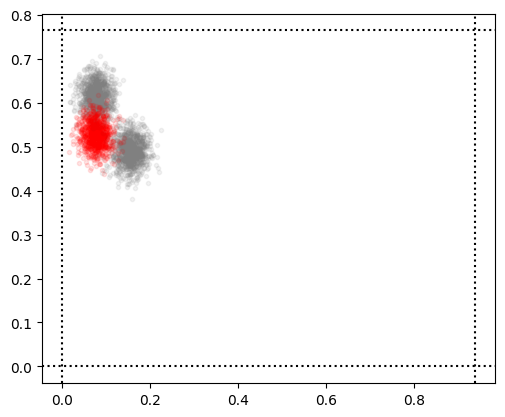

In [7]:
i = n_sites * 0
plt.plot(MDdata[:,i+1:i+3,0], MDdata[:,i+1:i+3,1], '.', alpha=0.1, c='gray')
plt.plot(MDdata[:,i,0], MDdata[:,i,1], '.', alpha=0.1, c='r')
plt.axvline(0, c='k', ls=':')
plt.axvline(MDbox.mean(axis=0)[0], c='k', ls=':')
plt.axhline(0, c='k', ls=':')
plt.axhline(MDbox.mean(axis=0)[1], c='k', ls=':')
plt.gca().set_aspect(1)

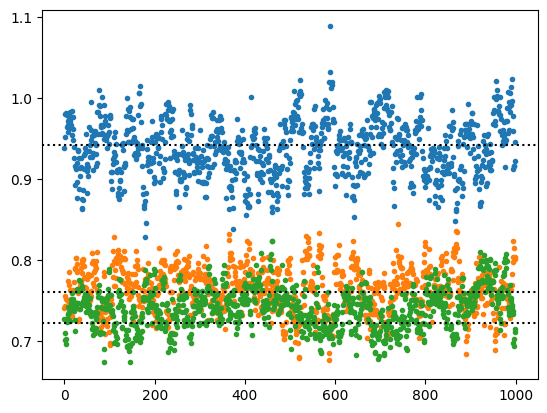

In [8]:
plt.plot(MDbox, '.')
for i in range(3):
    plt.axhline(box[i], ls=':', color='k')
# plt.ylim(0,None)
plt.show()

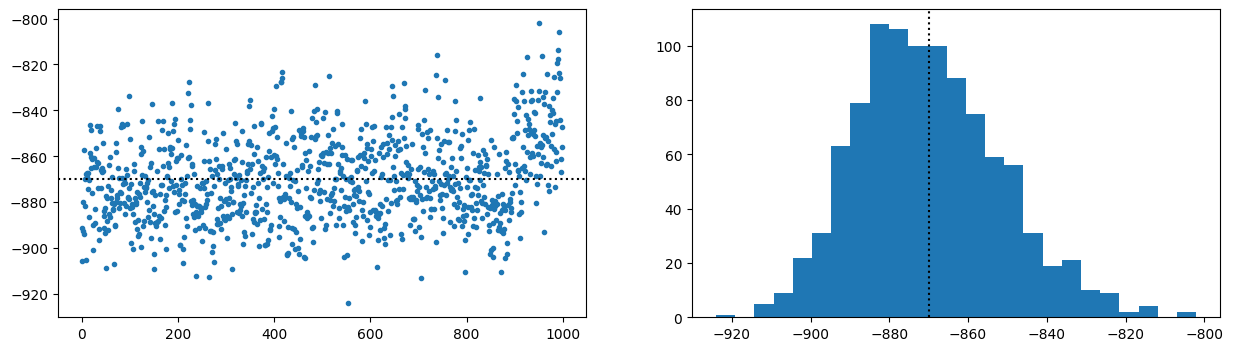

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(MDener, '.')
plt.axhline(MDener.mean(), ls=':', color='k')

plt.subplot(1,2,2)
plt.hist(MDener, bins='auto')
plt.axvline(MDener.mean(), ls=':', color='k')

plt.show()

In [10]:
get_view(MDdata, MDbox)

NGLWidget(max_frame=999)

In [13]:
info = f'iceIh_{water_type}-T{temp}'
index = -1
model.system.setDefaultPeriodicBoxVectors(*np.eye(3)*MDbox[index])
np.savez(f'data-{info}', positions=MDdata[index],  box=MDbox[index], energy=MDener[index])
with open(f'system-{info}.xml', 'w') as output:
    output.write(openmm.XmlSerializer.serialize(model.system))

In [51]:
np.savez("foo", positions=MDdata, box=MDbox)

In [49]:
box_mean = np.mean(MDbox, axis=0)
box_cov = np.cov(MDbox.T)

box_mean, box_cov

(array([0.93738384, 0.76394411, 0.74025662]),
 array([[ 0.00124461, -0.00053213, -0.00029769],
        [-0.00053213,  0.0007857 , -0.00012568],
        [-0.00029769, -0.00012568,  0.00064462]]))

In [38]:
import scipy
import scipy.stats

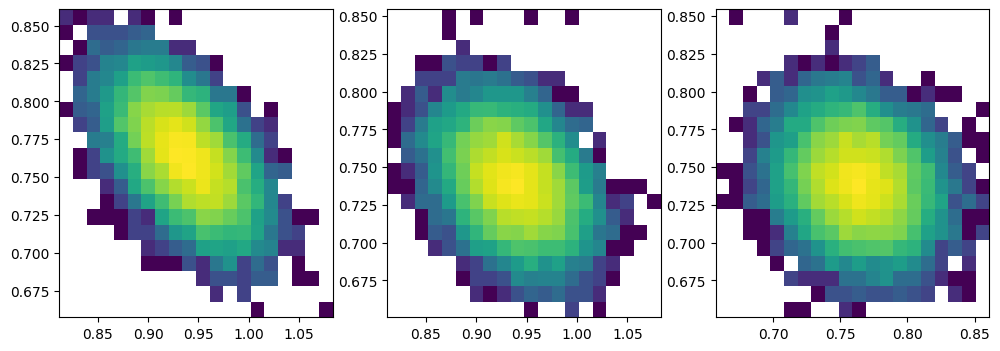

In [46]:
fake = scipy.stats.multivariate_normal(box_mean, box_cov).rvs(10000)

import itertools as it
import matplotlib.colors as mplc

ijs = list(it.combinations(range(3), r=2))
N = len(ijs)
plt.figure(figsize=(12, 4))
for k, (i, j) in enumerate(ijs, start=1):
    plt.subplot(1, N, k)
    plt.hist2d(fake[:, i], fake[:, j], bins=20, norm=mplc.LogNorm())

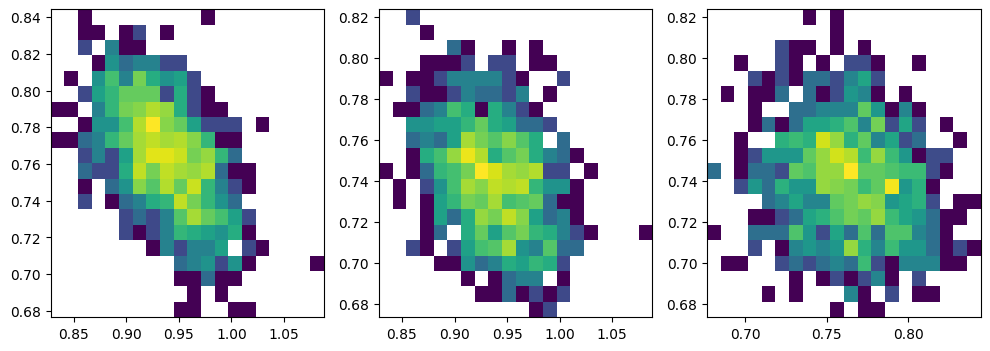

In [47]:
import itertools as it
import matplotlib.colors as mplc

ijs = list(it.combinations(range(3), r=2))
N = len(ijs)
plt.figure(figsize=(12, 4))
for k, (i, j) in enumerate(ijs, start=1):
    plt.subplot(1, N, k)
    plt.hist2d(MDbox[:, i], MDbox[:, j], bins=20, norm=mplc.LogNorm())